In [3]:
# Copyright (c) 2023 Quantum Brilliance Pty Ltd
# Methods adapted from source by T. Winkler (winker@ifis.uni-luebeck.de)
#         cf. https://www.ifis.uni-luebeck.de/index.php?id=762

import torch
import sys
import os
import time
import torchviz
import dataFormat
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from datetime import datetime
from torch import Tensor
from torch.optim import SGD, Adam
from subjectJoins import SubjectJoins
from qb.core import String, VectorString 
from qb.core.optimization import defaultAnsatzes, QMLParamCirc, QMLExecutor
sys.path.append(os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(sys.path[0]))), 'src', 'optimization', 'qml'))
from qb_qml_cpp import QuantumLayer, NormLayer

In [11]:
# Fix seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# default settings
settings = {
  "features": "simple",
  "reps": 5,
  "calc": "yz",
  "reward": "rational",
  "numEpisodes": 1000,
  "optimizer": "adam",
  "lr": 0.01
}

num_qubits = 4

# --------------------------------------------------------------
# ----------------- Begin quantum section ----------------------
# --------------------------------------------------------------

torch.set_default_dtype(torch.float64)
reps = settings["reps"]
param_gates = VectorString()
param_gates.append(String(["Ry"]))
param_gates.append(String(["Rz"]))
num_params = num_qubits*reps*len(param_gates)
circuit = QMLParamCirc(num_qubits, defaultAnsatzes.qrlRDBMS, reps, param_gates)
# Connect to PyTorch
initial_weights = np.pi*(2*np.random.rand(num_params) - 1)
quantum_nn = QuantumLayer(circuit, init_weights=initial_weights)

# --------------------------------------------------------------
# ------------------- End quantum section ----------------------
# --------------------------------------------------------------


# Define neural network 

normLayer = NormLayer()
model = torch.nn.Sequential(quantum_nn, normLayer)

[('0.inputs', Parameter containing:
tensor([1., 1., 1., 1.], requires_grad=True)), ('0.weights', Parameter containing:
tensor([-0.7883,  2.8319,  1.4577,  0.6199, -2.1613, -2.1615, -2.7766,  2.3008,
         0.6353,  1.3074, -3.0123,  2.9525,  2.0888, -1.8074, -1.9992, -1.9892,
        -1.2300,  0.1555, -0.4276, -1.3117,  0.7028, -2.2651, -1.3060, -0.8397,
        -0.2760,  1.7918, -1.8870,  0.0894,  0.5807, -2.8497,  0.6757, -2.0702,
        -2.7329,  2.8204,  2.9257,  1.9377, -1.2276, -2.5279,  1.1576, -0.3760],
       requires_grad=True))]


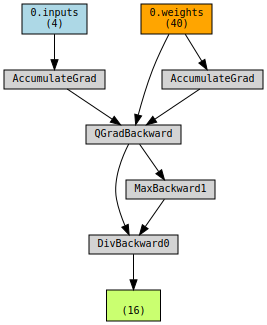

In [12]:
# Run code below to test if the model works + visualize the model
testtensor = torch.Tensor([1.0]*num_qubits)
testresult = model(testtensor)
# Printing all parameters that can have weights varied
print([param for param in model.named_parameters()]) 
# To visualise the computational graph of the NN
torchviz.make_dot(testresult,params=dict(model.named_parameters()))

In [14]:
# Code for running the model w/backprop
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Start Time =", current_time)
t1 = time.time()

env = SubjectJoins()
env.setRewardType(settings["reward"])
env.setFeatureType(settings["features"])

# load data
i_filename = "data.csv"
with open(i_filename, "r") as input:
  env.load_data(input)

# choose optimizer
if settings["optimizer"] == "adam":
  optimizer = Adam(model.parameters(), lr=settings["lr"], amsgrad=True)
elif settings["optimizer"] == "SGD":
  optimizer = SGD(model.parameters(), lr=settings["lr"], momentum=0.9)
else:
  optimizer = Adam(model.parameters(), lr=settings["lr"])

logInterval = 100
numEpisodes = settings["numEpisodes"]

print("Settings: ", settings)

# initialize variables for live evaluation
rewards = []
av_rewards = []
best_score = 0
rewardList = deque(maxlen=40)

# # initial observation
state = env.reset()

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=300, gamma=0.0009)

loss_arr = np.zeros(numEpisodes)
avg_reward_arr = np.zeros(numEpisodes - 100)
reward_arr = np.zeros(numEpisodes)
loss_fn = torch.nn.MSELoss()
# train the agent
for episode in range(numEpisodes):
  # learn a new state
  state = Tensor(state)
  prediction = model(state)
  selected = prediction.argmax()
  state, rewards, done, info = env.step(selected)
  # pad rewards to 16
  rewards.append(0)
  reward = rewards[selected]

  # calculate average for console output
  rewardList.append(reward)
  sumRewards = sum(rewardList)
  countRewards = len(rewardList)
  averageReward = sumRewards/countRewards
  # optimize
  loss = 0
  for i in range(0, len(rewards)):
    loss += (prediction[i] - rewards[i])**2
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  loss_arr[episode] = loss.item()
  reward_arr[episode] = averageReward
  if episode >= 100:
    avg_reward_arr[episode - 100] = np.mean(reward_arr[episode-100:episode])
  scheduler.step()
  # print current result
  print("Episode: {}, loss: {:.3f}, Reward : {:.3f}".format(episode, loss_arr[episode] , averageReward), end="\n")

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("End Time =", current_time)
t2 = time.time()
print("Time Taken = " + str(t2-t1) + " seconds")

Start Time = 21:30:28
Settings:  {'features': 'simple', 'reps': 5, 'calc': 'yz', 'reward': 'rational', 'numEpisodes': 1000, 'optimizer': 'adam', 'lr': 0.01}
Episode: 0, loss: 1.349, Reward : 0.974
Episode: 1, loss: 4.417, Reward : 0.754
Episode: 2, loss: 2.221, Reward : 0.816
Episode: 3, loss: 2.506, Reward : 0.748
Episode: 4, loss: 4.798, Reward : 0.798
Episode: 5, loss: 0.960, Reward : 0.817
Episode: 6, loss: 2.479, Reward : 0.843
Episode: 7, loss: 4.047, Reward : 0.851
Episode: 8, loss: 4.761, Reward : 0.865
Episode: 9, loss: 1.523, Reward : 0.841
Episode: 10, loss: 2.661, Reward : 0.838
Episode: 11, loss: 3.730, Reward : 0.817
Episode: 12, loss: 3.652, Reward : 0.820
Episode: 13, loss: 1.632, Reward : 0.780
Episode: 14, loss: 0.685, Reward : 0.795
Episode: 15, loss: 1.538, Reward : 0.771
Episode: 16, loss: 2.273, Reward : 0.785
Episode: 17, loss: 2.867, Reward : 0.742
Episode: 18, loss: 1.589, Reward : 0.756
Episode: 19, loss: 4.389, Reward : 0.762
Episode: 20, loss: 2.570, Reward 

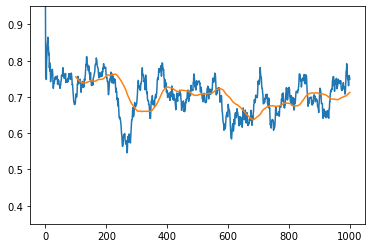

In [15]:
# Run code below to plot and save the obtained results 
plt.plot(np.arange(numEpisodes), reward_arr)
plt.savefig('reward_cpp.png')

plt.plot(np.arange(100, numEpisodes), avg_reward_arr)
plt.ylim([0.35, 0.95])
plt.savefig('avg_reward_cpp.png')

with open('cpp.npy', 'wb') as f:
  np.save(f, reward_arr)
  np.save(f, avg_reward_arr)